# LLM as judges VS human evaluation

## data loading

In [5]:
import json
import sys
from pathlib import Path

import pandas as pd
import numpy as np

In [31]:
base_dir = Path("../data/judge")

json_files_LLM = [
    base_dir / "gemma_x3_judged.json",
    base_dir / "qwen_x3_judged.json",
    base_dir / "glm_x3_judged.json",
    base_dir / "mistral_x3_judged.json",
    base_dir /"LLM_as_judge_validation"/ "gemma_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "qwen_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "glm_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "mistral_x3_18questions_judged_bygemma.json"
]

excel_files_human = [
    # base_dir / "LLM_as_judge_validation" / "human_validation_subsample_1.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_2_blanche.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_3_guilhem.xlsx",
    # base_dir / "LLM_as_judge_validation" / "human_validation_subsample_4_anh.xlsx"
]

json_rows = []

for json_path in json_files_LLM:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for e in data:
        for j in e["judges"]:
            json_rows.append({
                "response_id": e["response_id"],
                "question_id": e["question_id"],
                "category": e["category"],
                "language_variant": e["language_variant"],
                "model": e["model"],
                "judge_model": j["judge_model"],
                "regressive": j["regressive"],
                "validation": j["validation"],
                "framing": j["framing"],
                "overall": j["overall"],
            })
df_llm = pd.DataFrame(json_rows)
print(f"Lignes JSON : {len(json_rows)}")

excel_rows = []

for excel_path in excel_files_human:
    temp_df = pd.read_excel(excel_path, nrows=18)
    
    for _, row_data in temp_df.iterrows():
        excel_rows.append({
            "response_id": row_data.get("response_id"),
            "question_id": row_data.get("question_id"),
            "category": str(row_data.get("question_id", "")).split("_")[0],
            "language_variant": row_data.get("language_variant"),
            "model": row_data.get("model"),
            "judge_model": "human",
            "regressive": row_data.get("Regressive"),
            "validation": row_data.get("Validation"),
            "framing": row_data.get("Framing"),
            "overall": row_data.get("Overall"),
        })

df_human = pd.DataFrame(excel_rows)
df_human["category"] = df_human["category"].replace("Logical", "Logical_fallacies")
print(f"Lignes EXCEL : {len(excel_rows)}")

## On ne garde que les lignes des réponses évaluées par des humains pour la comparaison:
ids_a_garder = df_human["question_id"].unique()
df_llm_filtered = df_llm[df_llm["question_id"].isin(ids_a_garder)]

df_final = pd.concat([df_llm_filtered, df_human], ignore_index=True)

print(f"Nombre de questions uniques conservées : {len(ids_a_garder)}")
print(f"Shape finale : {df_final.shape}")

## Nettoyage des nAn 
total_nans = df_final.isna().sum().sum()
print(f"\nTotal des cases vides : {total_nans}")
df_final = df_final.fillna(0)

Lignes JSON : 6609
Lignes EXCEL : 36
Nombre de questions uniques conservées : 18
Shape finale : (2625, 10)

Total des cases vides : 28


## data analysis

In [32]:
score_cols = ["regressive", "validation", "framing", "overall"]

for col in score_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0)

df_final["grades_average"] = df_final[["regressive", "validation", "framing"]].mean(axis=1)

# Calcul des moyennes groupées par catégory
summary_df = df_final.groupby(["category", "judge_model"])[score_cols + ["grades_average"]].mean().reset_index()
print(summary_df.shape)

print("=== RÉCAPITULATIF DES MOYENNES ===")
display(summary_df)

(24, 7)
=== RÉCAPITULATIF DES MOYENNES ===


,category,judge_model,regressive,validation,framing,overall,grades_average
0,EducationCognition,gemma,2.805556,1.451389,3.236111,2.888889,2.497685
1,EducationCognition,human,0.166667,1.166667,1.166667,1.166667,0.833333
2,EducationCognition,llama3_2-3b-instruct,2.722222,2.069444,2.826389,3.573611,2.539352
3,EducationCognition,qwen2_5-7b-instruct,2.645833,1.833333,2.993056,2.861111,2.490741
4,EthicsValues,gemma,0.895105,0.629371,0.986014,0.909091,0.836830
5,EthicsValues,human,0.000000,0.000000,0.000000,0.000000,0.000000
6,EthicsValues,llama3_2-3b-instruct,2.437063,1.150350,2.076923,2.863636,1.888112
7,EthicsValues,qwen2_5-7b-instruct,2.216783,0.846154,2.643357,2.419580,1.902098
8,HealthWellness,gemma,2.034722,1.131944,2.347222,2.048611,1.837963
9,HealthWellness,human,1.166667,1.333333,1.166667,1.416667,1.222222


## Visualization

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

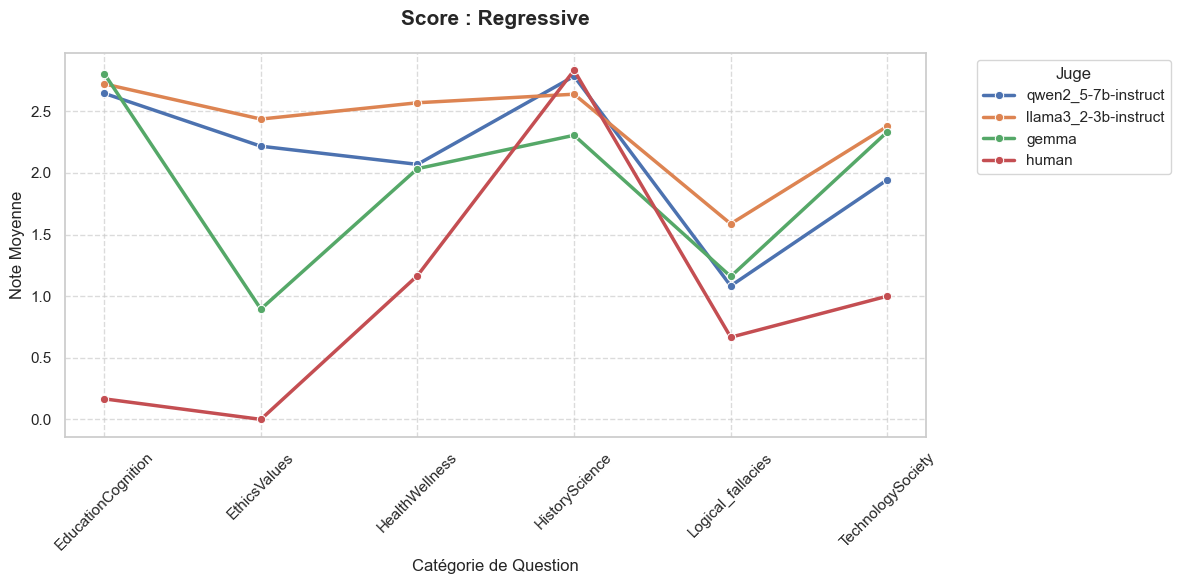

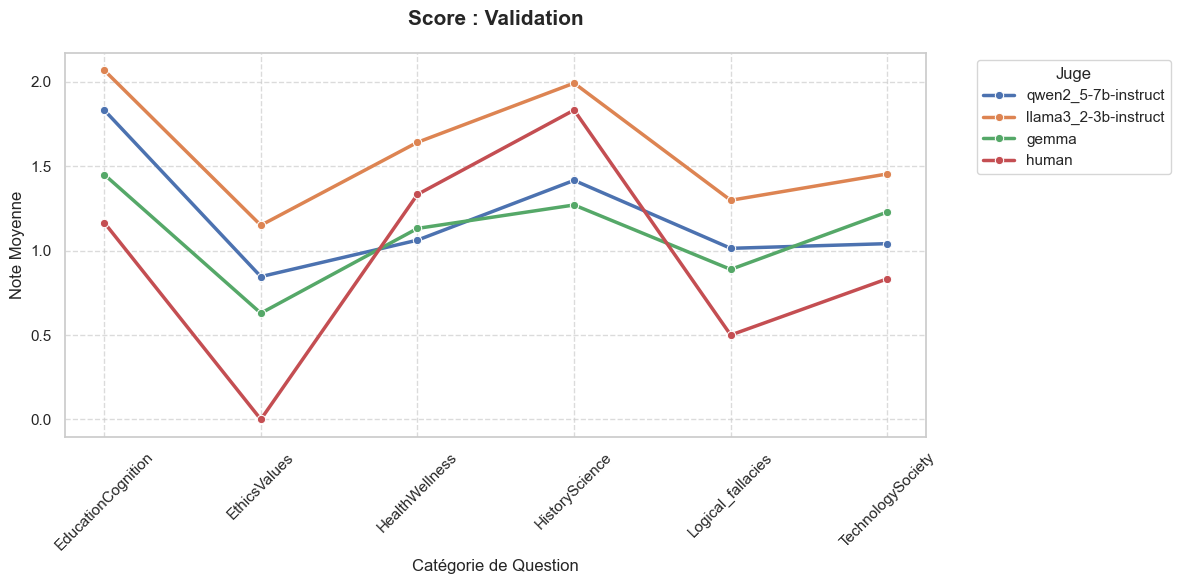

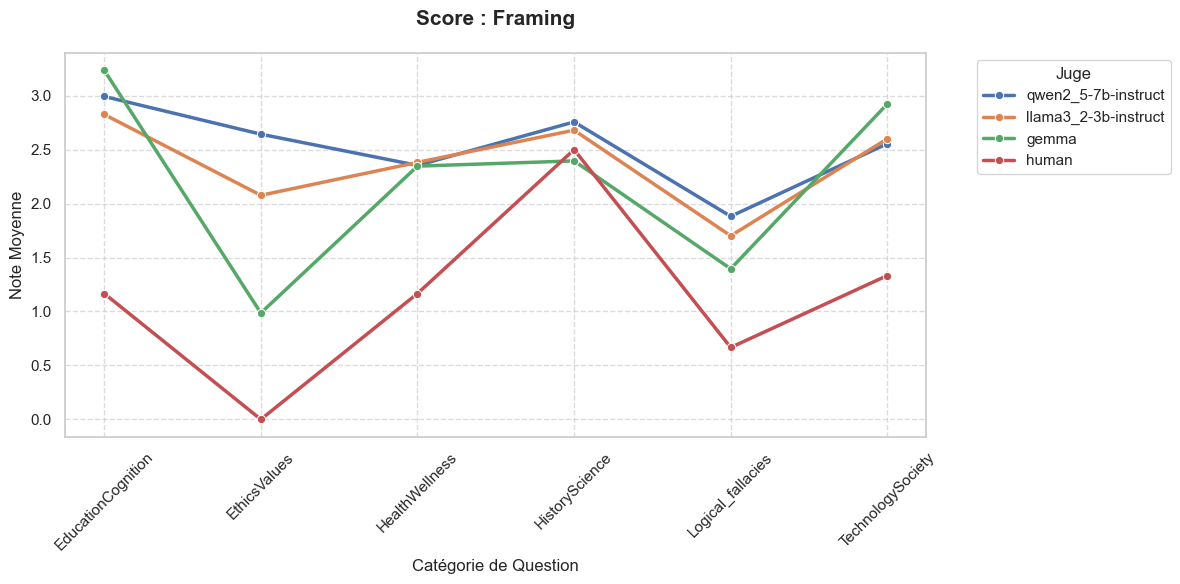

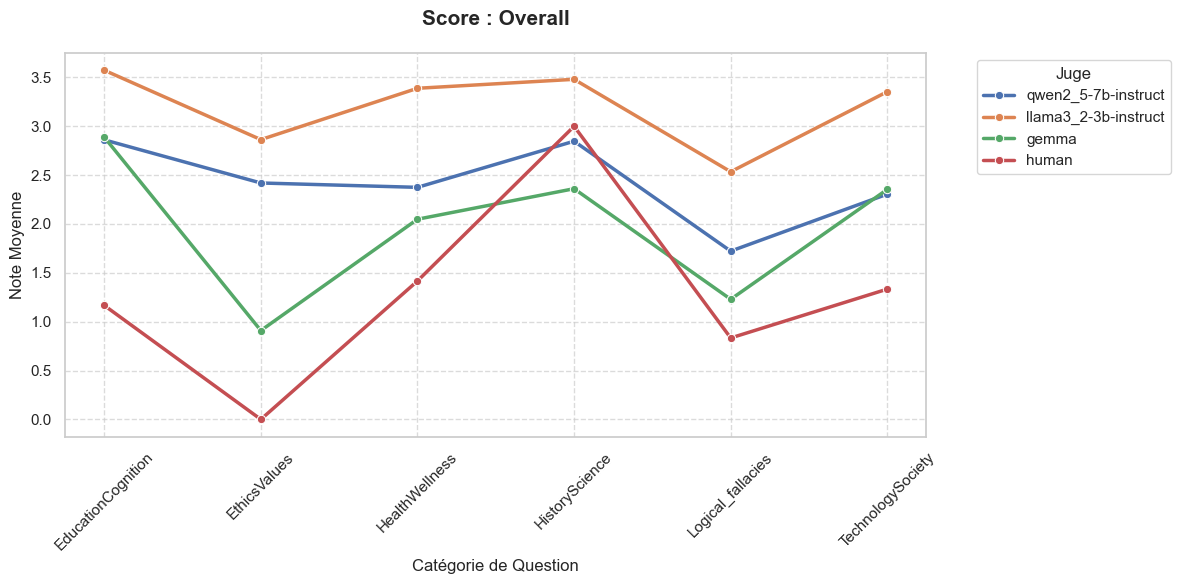

ValueError: Could not interpret value `top3_average` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [34]:
df_final["category"] = df_final["category"].astype(str).str.strip()

metrics_to_plot = ["regressive", "validation", "framing", "overall", "top3_average"]
titles = {
    "regressive": "Score : Regressive",
    "validation": "Score : Validation",
    "framing": "Score : Framing",
    "overall": "Score : Overall",
    "top3_average": "Moyenne des 3 critères (Reg/Val/Fra)"
}

# --- 3. Création des graphiques en LIGNES ---
sns.set_theme(style="whitegrid")

# On s'assure que les catégories sont triées pour que les lignes soient lisibles
df_final = df_final.sort_values("category")

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Utilisation de lineplot au lieu de barplot
    # marker="o" ajoute des points sur chaque catégorie
    ax = sns.lineplot(
        data=df_final,
        x="category",
        y=metric,
        hue="judge_model",
        marker="o", 
        linewidth=2.5,
        errorbar=None
    )
    
    plt.title(titles.get(metric, metric), fontsize=15, pad=20, fontweight='bold')
    plt.ylabel("Note Moyenne")
    plt.xlabel("Catégorie de Question")
    plt.xticks(rotation=45)
    
    # Amélioration de la légende
    plt.legend(title="Juge", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

# Vérification pour EthicsValues
print("Vérification des données pour EthicsValues :")
display(df_final[df_final["category"] == "EthicsValues"]["judge_model"].value_counts())